# Initial Experiments w Hierarchical Attention Mechanisms for External Memory

## Data

Model a "language modeling" task of predicting the next "word" in terms of a hidden Markov models.

$$
\begin{align*}
\mathcal{M} &= \{(x^{(t)}, y^{(t)})\}_{t \in [n_m]}\\
x^{(t)} &= (x_1^{(t)}, \ldots, x_l^{(t)})\\
y^{(t)} &= (y_1^{(t)}, \ldots, y_l^{(t)}) = (x_2^{(t)}, \ldots, x_{l+1}^{(t)})\\
\end{align*}
$$

where $x_i^{(t)}$ come from a hidden markov model.
$$
\begin{align*}
z_1^{(t)} &\sim \mu, z_{i+1}^{(t)} \sim P(\cdot | z_i^{(t)})\\
x_i^{(t)} &\sim O(\cdot | z_i^{(t)})
\end{align*}
$$

In [333]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import sys;sys.path.append('..')
import utils

## Generate Data

In [334]:
num_loops = 4
loop_length = 6 # for now, fixed length
num_notes = 6 # size of observation space

state_transition_edges = []

for l in range(num_loops):
    for s in range(loop_length):
        state_transition_edges.append((f's{l}{s}', f's{l}{(s+1)%loop_length}'))

    # NOTE: this adds connections between loops
    # for l2 in range(num_loops):
    #     state_transition_edges.append((f's{l}0', f's{l2}0'))

ImportError: requires pygraphviz http://pygraphviz.github.io/

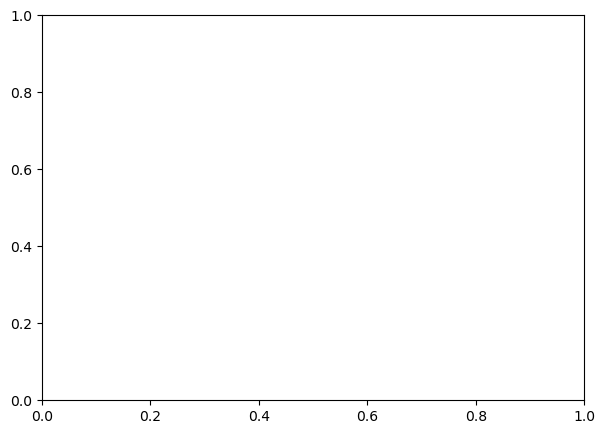

In [335]:
graph = nx.DiGraph(state_transition_edges)

color_map = ['tab:red' if node[-1]=='0' else 'tab:blue' for node in graph.nodes]
options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9, "font_color": "whitesmoke"}

fig, ax = plt.subplots(figsize=(7,5))
nx.draw_networkx(graph, with_labels=True, pos=nx.nx_agraph.graphviz_layout(graph, prog='circo'), node_color=color_map, ax=ax, **options)
ax.set_title('state transitions');

In [ ]:
states = list(graph.nodes())
state_to_idx = {s: i for i, s in enumerate(states)}
idx_to_state = {i: s for i, s in enumerate(states)}

emissions = [f'o{i}' for i in range(num_notes)]
idx_to_emission = {i: o for i,o in enumerate(emissions)}
emission_to_idx = {o: i for i,o in enumerate(emissions)}

In [ ]:
state_transition_matrix = np.array(nx.adjacency_matrix(graph, nodelist=state_to_idx.keys()).todense())
state_transition_matrix = state_transition_matrix / np.sum(state_transition_matrix, axis=0)[:, np.newaxis]

/var/folders/86/rz4f689d2sb1ld1x196j98zm0000gn/T/ipykernel_45318/216198539.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  state_transition_matrix = np.array(nx.adjacency_matrix(graph, nodelist=state_to_idx.keys()).todense())


In [ ]:
emissions_dict = {s: idx_to_emission[np.random.randint(num_notes)] for s in states}
emissions_dict

{'s00': 'o2',
 's01': 'o4',
 's02': 'o0',
 's03': 'o1',
 's04': 'o3',
 's05': 'o1',
 's10': 'o1',
 's11': 'o2',
 's12': 'o5',
 's13': 'o5',
 's14': 'o5',
 's15': 'o5',
 's20': 'o4',
 's21': 'o1',
 's22': 'o4',
 's23': 'o0',
 's24': 'o2',
 's25': 'o1',
 's30': 'o2',
 's31': 'o3',
 's32': 'o1',
 's33': 'o5',
 's34': 'o3',
 's35': 'o4'}

In [ ]:
emissions_matrix = np.zeros((len(states), num_notes))
for i, s in enumerate(states):
    emissions_matrix[i, emission_to_idx[emissions_dict[s]]] = 1

ImportError: requires pygraphviz http://pygraphviz.github.io/

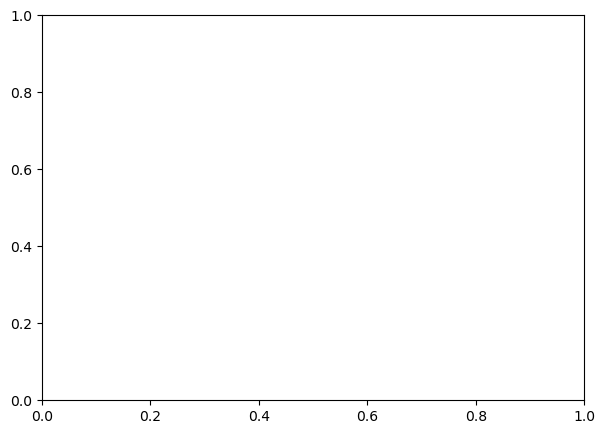

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
nx.draw_networkx(graph, with_labels=True, labels=emissions_dict,
    pos=nx.nx_agraph.graphviz_layout(graph, prog='circo'),
    node_color=color_map, ax=ax, **options)
ax.set_title('notes (emissions)');

In [ ]:
def sample_hmm(transition_matrix, emissions_matrix, initial_state, num_steps):
    current_state = initial_state
    states_seq = [current_state]
    emissions_seq = [np.random.choice(emissions, p=emissions_matrix[state_to_idx[current_state], :])]

    for i in range(num_steps-1):
        probabilities = transition_matrix[state_to_idx[current_state], :]
        next_state = np.random.choice(states, p=probabilities)
        states_seq.append(next_state)
        current_state = next_state
        emissions_seq.append(np.random.choice(emissions, p=emissions_matrix[state_to_idx[current_state], :]))
    return states_seq, emissions_seq

In [ ]:
mem_seq_len = loop_length + 1
input_seq_len = 2*loop_length

mem_seq_initial_states = [f's{l}0' for l in range(num_loops)]
input_seqs_initial_states = [f's{l}0' for l in range(num_loops)]

train_seqs = np.array([sample_hmm(state_transition_matrix, emissions_matrix, initial_state, input_seq_len+1) for initial_state in input_seqs_initial_states])
train_state_seqs, train_emissions_seqs = train_seqs[:, 0, :], train_seqs[:, 1, :]
train_seqs_x = train_emissions_seqs[:, :-1]
train_seqs_y = train_emissions_seqs[:, 1:]

test_seqs = np.array([sample_hmm(state_transition_matrix, emissions_matrix, initial_state, input_seq_len+1) for initial_state in input_seqs_initial_states])
test_state_seqs, test_emissions_seqs = test_seqs[:, 0, :], test_seqs[:, 1, :]
test_seqs_x = test_emissions_seqs[:, :-1]
test_seqs_y = test_emissions_seqs[:, 1:]


mem_seqs = np.array([sample_hmm(state_transition_matrix, emissions_matrix, initial_state, mem_seq_len + 1) for initial_state in mem_seq_initial_states])
mem_seqs = np.repeat(np.expand_dims(mem_seqs, axis=0), axis=0, repeats=len(train_seqs))
mem_state_seqs, mem_emissions_seqs = mem_seqs[:, :, 0, :], mem_seqs[:, :, 1, :]
mem_seqs_x = mem_emissions_seqs[:, :, :-1]
mem_seqs_y = mem_emissions_seqs[:, :, 1:]


In [ ]:
print(f'train_seqs_x.shape: {train_seqs_x.shape}; train_seqs_y.shape: {train_seqs_y.shape}') # shape [batch_size, seq_len]
print(f'mem_seqs_x.shape: {mem_seqs_x.shape}; mem_seqs_y.shape: {mem_seqs_y.shape}') # shape [batch_size, num_mem_seqs, mem_seq_len]

train_seqs_x.shape: (4, 12); train_seqs_y.shape: (4, 12)
mem_seqs_x.shape: (4, 4, 7); mem_seqs_y.shape: (4, 4, 7)


In [ ]:
mem_state_seqs[0]

array([['s00', 's01', 's02', 's03', 's04', 's05', 's00', 's01'],
       ['s10', 's11', 's12', 's13', 's14', 's15', 's10', 's11'],
       ['s20', 's21', 's22', 's23', 's24', 's25', 's20', 's21'],
       ['s30', 's31', 's32', 's33', 's34', 's35', 's30', 's31']],
      dtype='<U3')

In [ ]:
mem_seqs_x[0]

array([['o2', 'o4', 'o0', 'o1', 'o3', 'o1', 'o2'],
       ['o1', 'o2', 'o5', 'o5', 'o5', 'o5', 'o1'],
       ['o4', 'o1', 'o4', 'o0', 'o2', 'o1', 'o4'],
       ['o2', 'o3', 'o1', 'o5', 'o3', 'o4', 'o2']], dtype='<U3')

In [ ]:
train_seqs_x

array([['o2', 'o4', 'o0', 'o1', 'o3', 'o1', 'o2', 'o4', 'o0', 'o1', 'o3',
        'o1'],
       ['o1', 'o2', 'o5', 'o5', 'o5', 'o5', 'o1', 'o2', 'o5', 'o5', 'o5',
        'o5'],
       ['o4', 'o1', 'o4', 'o0', 'o2', 'o1', 'o4', 'o1', 'o4', 'o0', 'o2',
        'o1'],
       ['o2', 'o3', 'o1', 'o5', 'o3', 'o4', 'o2', 'o3', 'o1', 'o5', 'o3',
        'o4']], dtype='<U3')

In [ ]:
maptoidx = np.vectorize(lambda x: emission_to_idx[x])
train_seqs_x = maptoidx(train_seqs_x)
train_seqs_y = maptoidx(train_seqs_y)
test_seqs_x = maptoidx(test_seqs_x)
test_seqs_y = maptoidx(test_seqs_y)
mem_seqs_x = maptoidx(mem_seqs_x)
mem_seqs_y = maptoidx(mem_seqs_y)

In [ ]:
mem_seqs_x

array([[[2, 4, 0, 1, 3, 1, 2],
        [1, 2, 5, 5, 5, 5, 1],
        [4, 1, 4, 0, 2, 1, 4],
        [2, 3, 1, 5, 3, 4, 2]],

       [[2, 4, 0, 1, 3, 1, 2],
        [1, 2, 5, 5, 5, 5, 1],
        [4, 1, 4, 0, 2, 1, 4],
        [2, 3, 1, 5, 3, 4, 2]],

       [[2, 4, 0, 1, 3, 1, 2],
        [1, 2, 5, 5, 5, 5, 1],
        [4, 1, 4, 0, 2, 1, 4],
        [2, 3, 1, 5, 3, 4, 2]],

       [[2, 4, 0, 1, 3, 1, 2],
        [1, 2, 5, 5, 5, 5, 1],
        [4, 1, 4, 0, 2, 1, 4],
        [2, 3, 1, 5, 3, 4, 2]]])

In [ ]:
train_seqs_x
test_seqs_x

array([[2, 4, 0, 1, 3, 1, 2, 4, 0, 1, 3, 1],
       [1, 2, 5, 5, 5, 5, 1, 2, 5, 5, 5, 5],
       [4, 1, 4, 0, 2, 1, 4, 1, 4, 0, 2, 1],
       [2, 3, 1, 5, 3, 4, 2, 3, 1, 5, 3, 4]])

### Define Memory Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

train_ds = tf.data.Dataset.from_tensor_slices(((train_seqs_x, mem_seqs_x, mem_seqs_y), train_seqs_y)).batch(4)
test_ds = tf.data.Dataset.from_tensor_slices(((test_seqs_x, mem_seqs_x, mem_seqs_y), test_seqs_y)).batch(4)

In [ ]:
from transformer_modules import create_positional_encoding

# TODO: add this layer to some module

class MemoryAddPositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, name="add_positional_embedding"):
        super().__init__(name=name)

    def build(self, input_shape):
        _, self.n_m, self.seq_length, self.vec_dim = input_shape
        self.pos_encoding = create_positional_encoding(length=self.seq_length, depth=self.vec_dim)

    def call(self, x):
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.vec_dim, tf.float32))
        
        # add positional encoding
        x = x + self.pos_encoding[tf.newaxis, :, :]

        return x

## Kernel Model1, two layernorm & softmax in the end (from_logit = False)

In [ ]:

from transformer_modules import AddPositionalEmbedding
import numpy as np
class MemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, **kwargs):
        super().__init__(**kwargs)

        self.alpha_it = None
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different attention layers for input and memories
        self.self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim//n_heads, value_dim=embedding_dim//n_heads, name='self_attn')
        self.memory_self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim//n_heads, value_dim=embedding_dim//n_heads, name='mem_self_attn')
        
        # FF layer
        self.output_dense = layers.Dense(vocab_size, name='output')
       
        # create cross attention layer
        self.cross_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, value_dim=embedding_dim//n_heads, name='cross_attn')
        
        # normalization
        self.layernorm = layers.LayerNormalization()

    def self_attention(self, seq):
        return self.self_attention_layer(seq, seq, use_causal_mask=True)

    def memory_self_attention(self, mem_seqs):
        lambda_fn = lambda x: self.memory_self_attention_layer(x, x, use_causal_mask=False)
        return tf.map_fn(lambda_fn, mem_seqs)

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)
        
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)
       
        embedded_input_seqs = self.self_attention(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs)
        # embedded_input_seqs.shape (batch_size, input_length, embedding_dim)
        # embedded_mem_x_seqs.shape (batch_size, num_memories, memory_length, embedding_dim)

        w_it_list = []
        logit_list = []
        # compute cross_attention_output here
        for t in range(embedded_mem_x_seqs.shape[1]):
            cross_attention_output = self.cross_attention_layer(
                query=embedded_input_seqs, 
                value=embedded_mem_y_seqs[:,t,:,:], 
                key=embedded_mem_x_seqs[:,t,:,:])
            # cross_attention_output.shape (batch_size, input_seq_length, embedding dim)

            # Compute logits from cross_attention_output
            # First Layer normalization here
            logits = self.layernorm(self.output_dense(cross_attention_output))
            
            logit_list.append(logits)
            sums = []
            for i in range(input_seq_len):
                sum_up_to_i = tf.reduce_sum(logits[:, :i, :], axis=1)
                sums.append(sum_up_to_i)
            # calc w_it for each t
            # to stack the results along the second dimension again
            w_it = tf.stack(sums, axis=1)  
            w_it_list.append(w_it)
        w_it_list = tf.stack(w_it_list, axis = 1)
        # w_it_list.shape （batch_size, num_memory, input_seq_length, vocab_size)

        logits_list = tf.stack(logit_list, axis = 1)
        # logits_list.shape （batch_size, num_memory, input_seq_length, vocab_size)
        
        alpha_it = tf.nn.softmax(w_it_list, axis=1)
        # alpha_it_list.shape （batch_size, num_memory, input_seq_length, vocab_size)
        
        self.alpha_it = alpha_it
        
        # Elementwise multiplication
        multiplied_tensor = alpha_it * tf.math.exp(logits_list)
    
        # Sum over t
        result = tf.reduce_sum(multiplied_tensor, axis=1)
        # Layer normalization here 
        result = self.layernorm(result)
        result = tf.nn.softmax(result, axis=2)
        # result.shape （batch_size, input_seq_length, vocab_size)
       
        return result

In [ ]:
vocab_size = num_notes
embedding_dim = num_notes // 3
n_heads = 2
memory_model1 = MemoryModel(vocab_size, embedding_dim=embedding_dim, key_dim=embedding_dim // n_heads, n_heads=n_heads, name='memory_model')
memory_model1([train_seqs_x, mem_seqs_x, mem_seqs_y]); # build model

create_opt = lambda: tf.optimizers.Adam(learning_rate=1e-2)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
memory_model1.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model1.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  12        
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0 (unused)
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 self_attn (MultiHeadAttenti  multiple                 24        
 on)                                                             
                                                                 
 mem_self_attn (MultiHeadAtt  multiple                 24        
 ention)                                              

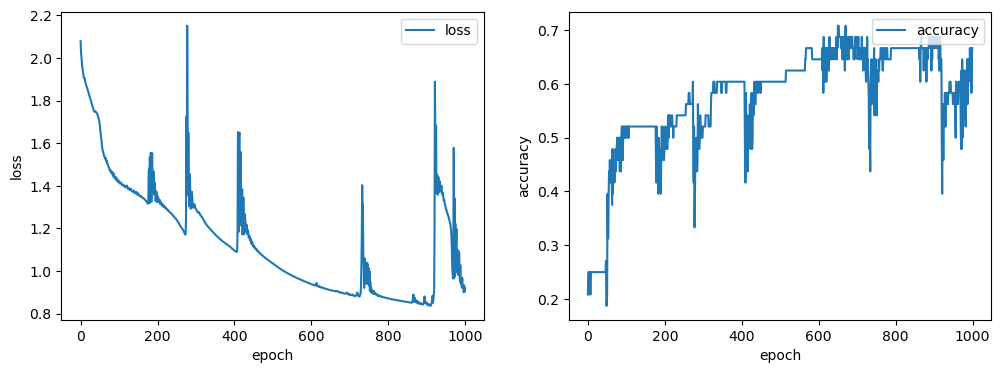

In [ ]:
history1 = memory_model1.fit(train_ds, epochs=1000, verbose=0)
utils.plot_history(history1, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

1/1 [==============================] - 1s 519ms/step


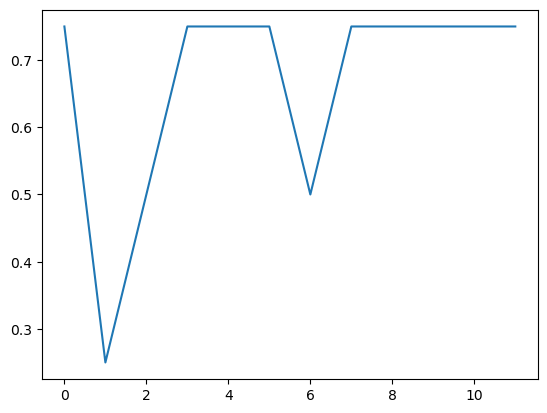

In [ ]:
memory_model1.evaluate(train_ds)
memory_model1.evaluate(test_ds)

# plot accuracy as a function of position in sequence
preds1 = memory_model1.predict(train_ds)
preds1 = np.argmax(preds1, axis=-1)
acc_by_pos1 = np.mean(preds1 == train_seqs_y, axis=0)
plt.plot(acc_by_pos1)

## Utility functions

In [ ]:

def plot_seq_attention(attn_, mem_seqs_x, train_seqs_x):
    num_mem_seqs = attn_.shape[0]
    fig, ax = plt.subplots(figsize=(num_mem_seqs*4,8))
    im = ax.imshow(attn_, cmap='gray', vmin=0, vmax=1)
    ax.set_yticks(range(len(mem_seqs_x)))
    ax.set_xticks(range(len(train_seqs_x)))
    ax.set_yticklabels([tuple(x) for x in mem_seqs_x]);
    ax.set_xticklabels(train_seqs_x);

    ax.set_xlabel('input sequence')
    ax.set_ylabel('memory sequences')
    ax.set_title('attention over sequences')

    fig.colorbar(im, ax=ax)
    

def plot_attention(sample_input_index, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model):
    """
    choose sample input and plot the attention (memory_seq versus each input element), call plot_seq_attention as subfunction
    """
    b = sample_input_index
    sample_input = seqs_x_train[b:b+1]
    print("sample_input: ",sample_input)
    sample_mem_seq_x = mem_seqs_x_train[b:b+1]
    sample_mem_seq_y = mem_seqs_y_train[b:b+1]

    pred = memory_model([sample_input, sample_mem_seq_x, sample_mem_seq_y])
    pred = np.argmax(pred, axis=-1)
    print(f'prediction: {pred[0]}')
    print(f'y: {seqs_y_train[b]}')
    print(pred[0] == seqs_y_train[b])
    attn_ = memory_model.alpha_it[0]
    prob_list = []
    for i in range(attn_.shape[1]):
        prob_list.append(attn_[:,i,pred[0][i]])

    attn_output_seq = tf.stack(prob_list, axis = 1)
    #print(attn_output_seq.shape)
    plot_seq_attention(attn_output_seq, sample_mem_seq_x[0], sample_input[0])

sample_input:  [[1 2 5 5 5 5 1 2 5 5 5 5]]
prediction: [2 4 4 5 5 5 5 5 5 5 5 5]
y: [2 5 5 5 5 1 2 5 5 5 5 1]
[ True False False  True  True False False  True  True  True  True False]


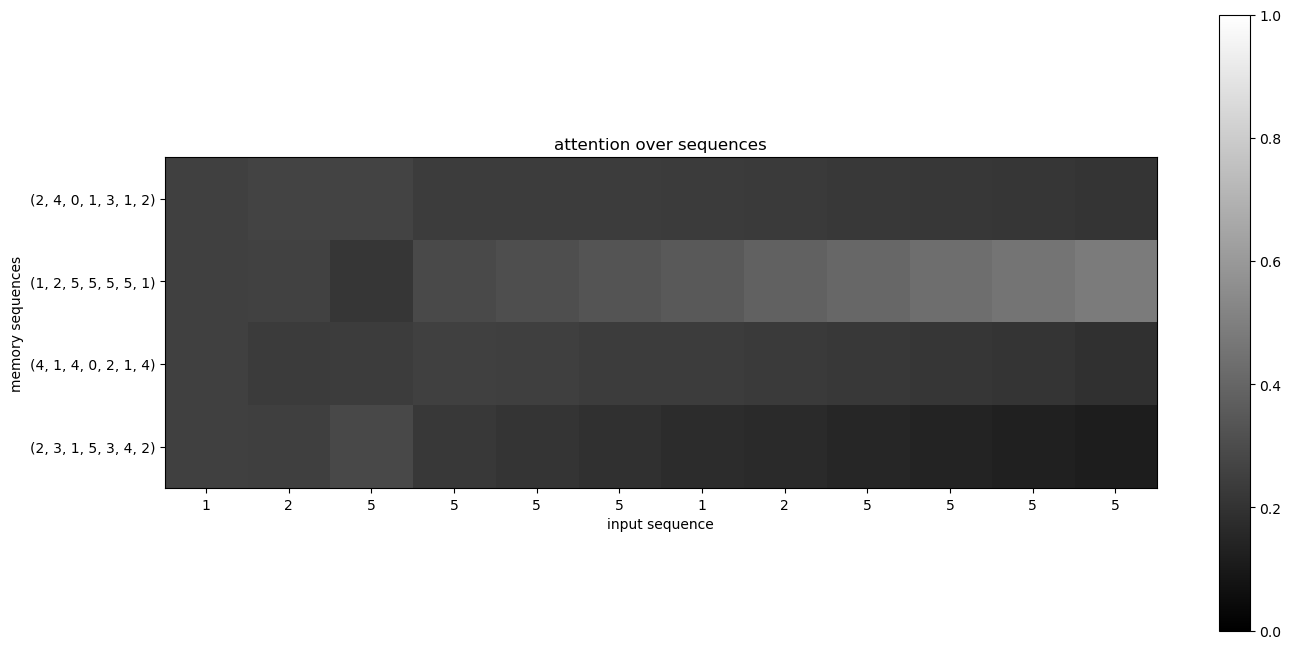

In [ ]:
idx = 1
plot_attention(idx, train_seqs_x, train_seqs_y, mem_seqs_x, mem_seqs_y, memory_model1)

sample_input:  [[2 3 1 5 3 4 2 3 1 5 3 4]]
prediction: [4 5 2 5 5 2 5 5 2 5 5 2]
y: [3 1 5 3 4 2 3 1 5 3 4 2]
[False False False False False  True False False False False False  True]


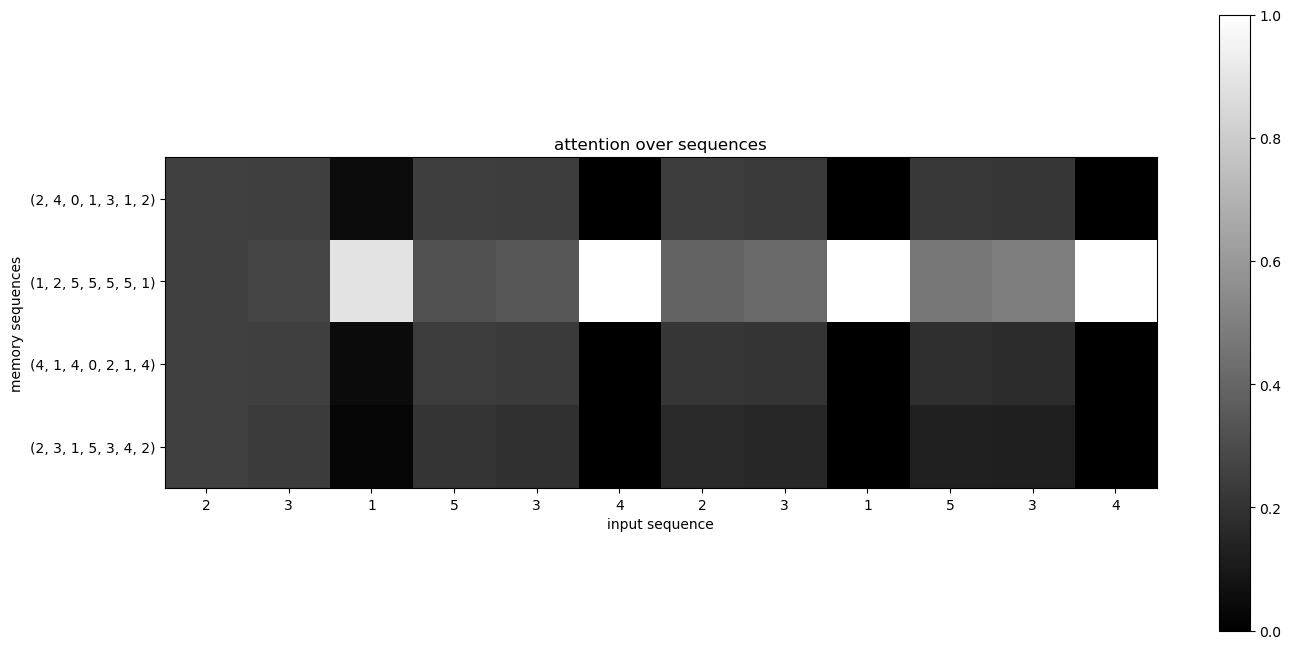

In [ ]:
idx = 3
plot_attention(idx, train_seqs_x, train_seqs_y, mem_seqs_x, mem_seqs_y, memory_model1)

## Kernel Model2, two layernorm, no softmax in the end and from_logit = True

In [ ]:

from transformer_modules import AddPositionalEmbedding
import numpy as np
class MemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, **kwargs):
        super().__init__(**kwargs)

        self.alpha_it = None
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different attention layers for input and memories
        self.self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim//n_heads, value_dim=embedding_dim//n_heads, name='self_attn')
        self.memory_self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim//n_heads, value_dim=embedding_dim//n_heads, name='mem_self_attn')
        
        # FF layer
        self.output_dense = layers.Dense(vocab_size, name='output')
       
        # create cross attention layer
        self.cross_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, value_dim=embedding_dim//n_heads, name='cross_attn')
        
        # normalization
        self.layernorm = layers.LayerNormalization()

    def self_attention(self, seq):
        return self.self_attention_layer(seq, seq, use_causal_mask=True)

    def memory_self_attention(self, mem_seqs):
        lambda_fn = lambda x: self.memory_self_attention_layer(x, x, use_causal_mask=False)
        return tf.map_fn(lambda_fn, mem_seqs)

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)
        
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)
       
        embedded_input_seqs = self.self_attention(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs)
        # embedded_input_seqs.shape (batch_size, input_length, embedding_dim)
        # embedded_mem_x_seqs.shape (batch_size, num_memories, memory_length, embedding_dim)

        w_it_list = []
        logit_list = []
        # compute cross_attention_output here
        for t in range(embedded_mem_x_seqs.shape[1]):
            cross_attention_output = self.cross_attention_layer(
                query=embedded_input_seqs, 
                value=embedded_mem_y_seqs[:,t,:,:], 
                key=embedded_mem_x_seqs[:,t,:,:])
            # cross_attention_output.shape (batch_size, input_seq_length, embedding dim)

            # Compute logits from cross_attention_output
            # First Layer normalization here
            logits = self.layernorm(self.output_dense(cross_attention_output))
            
            logit_list.append(logits)
            sums = []
            for i in range(input_seq_len):
                sum_up_to_i = tf.reduce_sum(logits[:, :i, :], axis=1)
                sums.append(sum_up_to_i)
            # calc w_it for each t
            # to stack the results along the second dimension again
            w_it = tf.stack(sums, axis=1)  
            w_it_list.append(w_it)
        w_it_list = tf.stack(w_it_list, axis = 1)
        # w_it_list.shape （batch_size, num_memory, input_seq_length, vocab_size)

        logits_list = tf.stack(logit_list, axis = 1)
        # logits_list.shape （batch_size, num_memory, input_seq_length, vocab_size)
        
        alpha_it = tf.nn.softmax(w_it_list, axis=1)
        # alpha_it_list.shape （batch_size, num_memory, input_seq_length, vocab_size)
        
        self.alpha_it = alpha_it
        
        # Elementwise multiplication
        multiplied_tensor = alpha_it * tf.math.exp(logits_list)
    
        # Sum over t
        result = tf.reduce_sum(multiplied_tensor, axis=1)
        # Layer normalization here 
        result = self.layernorm(result)
        # result.shape （batch_size, input_seq_length, vocab_size)
       
        return result

In [ ]:
vocab_size = num_notes
embedding_dim = num_notes // 3
n_heads = 1
memory_model2 = MemoryModel(vocab_size, embedding_dim=embedding_dim, key_dim=embedding_dim // n_heads, n_heads=n_heads, name='memory_model')
memory_model2([train_seqs_x, mem_seqs_x, mem_seqs_y]); # build model

create_opt = lambda: tf.optimizers.Adam(learning_rate=1e-2)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
memory_model2.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model2.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  12        
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0 (unused)
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 self_attn (MultiHeadAttenti  multiple                 24        
 on)                                                             
                                                                 
 mem_self_attn (MultiHeadAtt  multiple                 24        
 ention)                                              

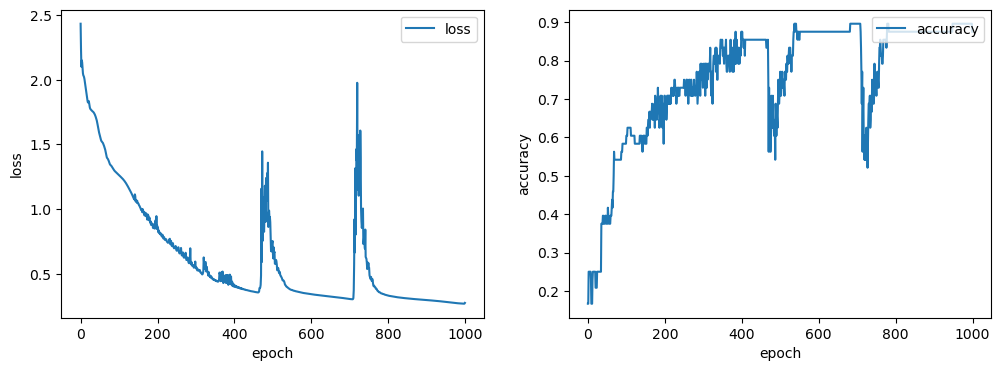

In [ ]:
history2 = memory_model2.fit(train_ds, epochs=1000, verbose=0)
utils.plot_history(history2, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

1/1 [==============================] - 1s 515ms/step


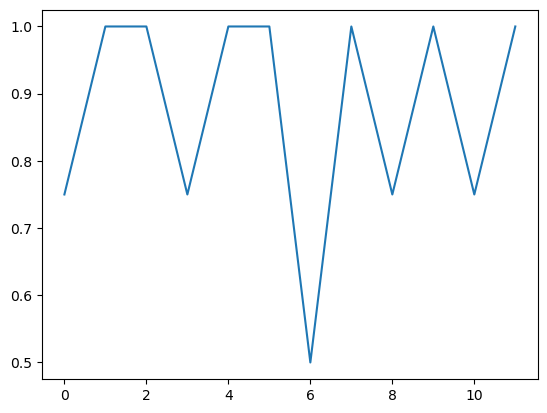

In [ ]:
memory_model2.evaluate(train_ds)
memory_model2.evaluate(test_ds)

# plot accuracy as a function of position in sequence
preds2 = memory_model2.predict(train_ds)
preds2 = np.argmax(preds2, axis=-1)
acc_by_pos2 = np.mean(preds2 == train_seqs_y, axis=0)
plt.plot(acc_by_pos2)

sample_input:  [[1 2 5 5 5 5 1 2 5 5 5 5]]
prediction: [2 5 5 5 5 1 5 5 5 5 5 1]
y: [2 5 5 5 5 1 2 5 5 5 5 1]
[ True  True  True  True  True  True False  True  True  True  True  True]


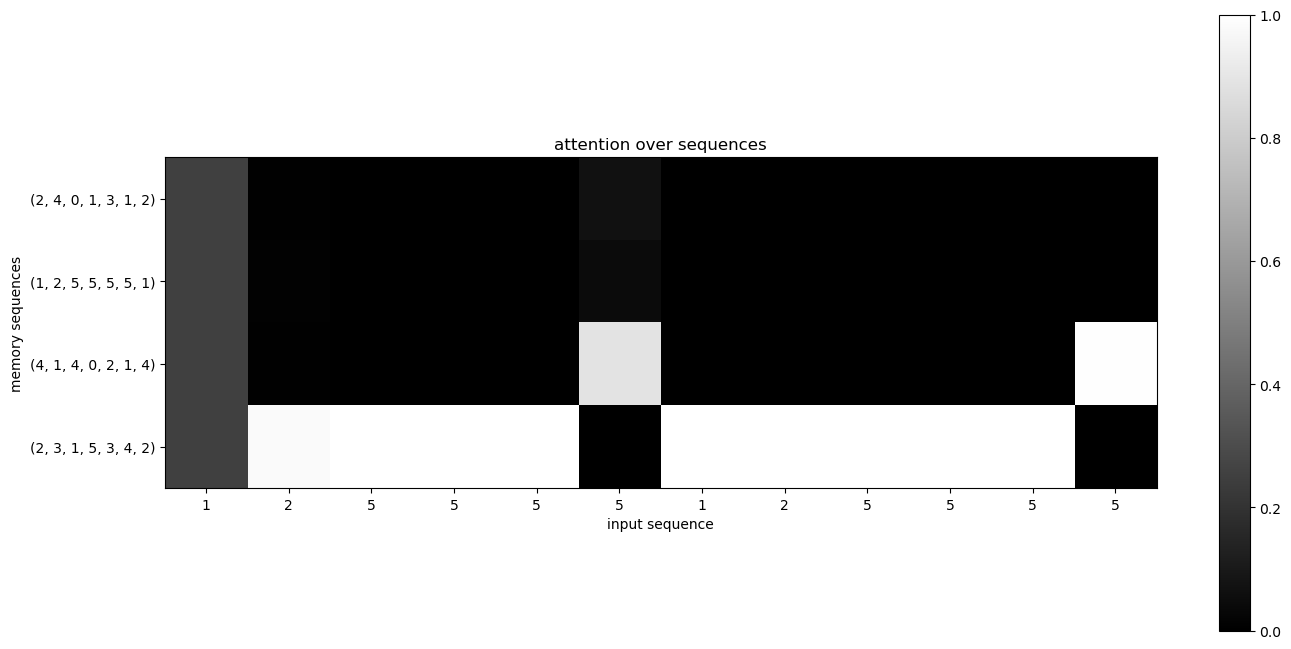

In [ ]:
idx = 1
plot_attention(idx, train_seqs_x, train_seqs_y, mem_seqs_x, mem_seqs_y, memory_model2)

sample_input:  [[2 3 1 5 3 4 2 3 1 5 3 4]]
prediction: [3 1 5 4 4 2 3 1 5 3 3 2]
y: [3 1 5 3 4 2 3 1 5 3 4 2]
[ True  True  True False  True  True  True  True  True  True False  True]


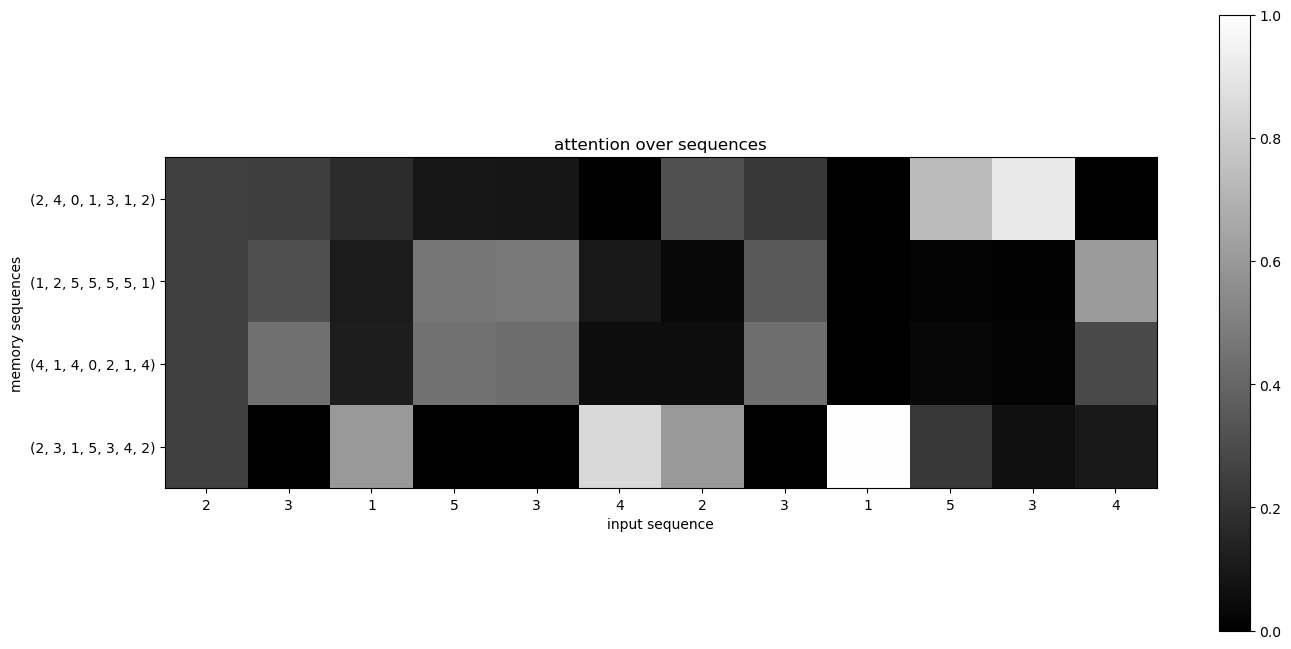

In [ ]:
idx = 3
plot_attention(idx, train_seqs_x, train_seqs_y, mem_seqs_x, mem_seqs_y, memory_model2)

sample_input:  [[4 1 4 0 2 1 4 1 4 0 2 1]]
prediction: [1 4 0 2 1 4 1 4 0 2 1 4]
y: [1 4 0 2 1 4 1 4 0 2 1 4]
[ True  True  True  True  True  True  True  True  True  True  True  True]


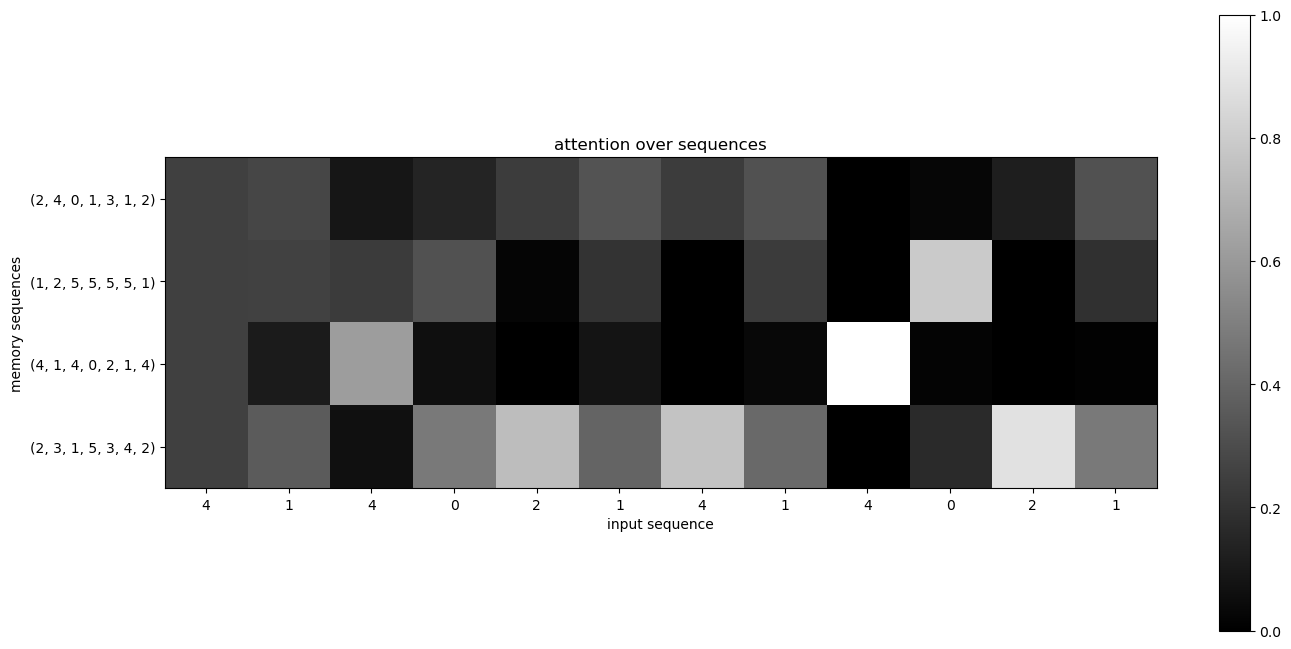

In [ ]:
idx = 2
plot_attention(idx, train_seqs_x, train_seqs_y, mem_seqs_x, mem_seqs_y, memory_model1)

## Kernel Model3, no layernorm, normalize s.t vocab prob axis sums to 1, from_logit = False

In [353]:

from transformer_modules import AddPositionalEmbedding
import numpy as np
class MemoryModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, **kwargs):
        super().__init__(**kwargs)

        self.alpha_it = None
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different attention layers for input and memories
        self.self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim//n_heads, value_dim=embedding_dim//n_heads, name='self_attn')
        self.memory_self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim//n_heads, value_dim=embedding_dim//n_heads, name='mem_self_attn')
        
        # FF layer
        self.output_dense = layers.Dense(vocab_size, name='output')
       
        # create cross attention layer
        self.cross_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, value_dim=embedding_dim//n_heads, name='cross_attn')
        
        # normalization
        self.layernorm = layers.LayerNormalization()

    def self_attention(self, seq):
        return self.self_attention_layer(seq, seq, use_causal_mask=True)

    def memory_self_attention(self, mem_seqs):
        lambda_fn = lambda x: self.memory_self_attention_layer(x, x, use_causal_mask=False)
        return tf.map_fn(lambda_fn, mem_seqs)

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_x_input)
        embedded_mem_y_seqs = self.embedder(memory_y_input)
        
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)
       
        embedded_input_seqs = self.self_attention(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs)
        # embedded_input_seqs.shape (batch_size, input_length, embedding_dim)
        # embedded_mem_x_seqs.shape (batch_size, num_memories, memory_length, embedding_dim)

        w_it_list = []
        logit_list = []
        # compute cross_attention_output here
        for t in range(embedded_mem_x_seqs.shape[1]):
            cross_attention_output = self.cross_attention_layer(
                query=embedded_input_seqs, 
                value=embedded_mem_y_seqs[:,t,:,:], 
                key=embedded_mem_x_seqs[:,t,:,:])
            # cross_attention_output.shape (batch_size, input_seq_length, embedding dim)

            # Compute logits from cross_attention_output
            # First Layer normalization here
            logits = self.output_dense(cross_attention_output)
            
            logit_list.append(logits)
            sums = []
            for i in range(input_seq_len):
                sum_up_to_i = tf.reduce_sum(logits[:, :i, :], axis=1)
                sums.append(sum_up_to_i)
            # calc w_it for each t
            # to stack the results along the second dimension again
            w_it = tf.stack(sums, axis=1)  
            w_it_list.append(w_it)
        w_it_list = tf.stack(w_it_list, axis = 1)
        # w_it_list.shape （batch_size, num_memory, input_seq_length, vocab_size)

        logits_list = tf.stack(logit_list, axis = 1)
        # logits_list.shape （batch_size, num_memory, input_seq_length, vocab_size)
        
        alpha_it = tf.nn.softmax(w_it_list, axis=1)
        # alpha_it_list.shape （batch_size, num_memory, input_seq_length, vocab_size)
        
        self.alpha_it = alpha_it
        
        # Elementwise multiplication
        multiplied_tensor = alpha_it * tf.math.exp(logits_list)
    
        # Sum over t
        result = tf.reduce_sum(multiplied_tensor, axis=1)
        # tf.print(tf.reduce_sum(result, axis=2)) not sum to 1
        # Layer normalization here 
        result = result / (tf.reduce_sum(result, axis = 2)[:,:,np.newaxis])
        #tf.print(tf.reduce_sum(result, axis=2)) #should sum to 1 now
        # result.shape （batch_size, input_seq_length, vocab_size)
       
        return result

In [354]:
vocab_size = num_notes
embedding_dim = num_notes // 3
n_heads = 1
memory_model3 = MemoryModel(vocab_size, embedding_dim=embedding_dim, key_dim=embedding_dim // n_heads, n_heads=n_heads, name='memory_model')
memory_model3([train_seqs_x, mem_seqs_x, mem_seqs_y]); # build model

create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
memory_model3.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model3.summary()

Model: "memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  12        
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0 (unused)
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 self_attn (MultiHeadAttenti  multiple                 24        
 on)                                                             
                                                                 
 mem_self_attn (MultiHeadAtt  multiple                 24        
 ention)                                              

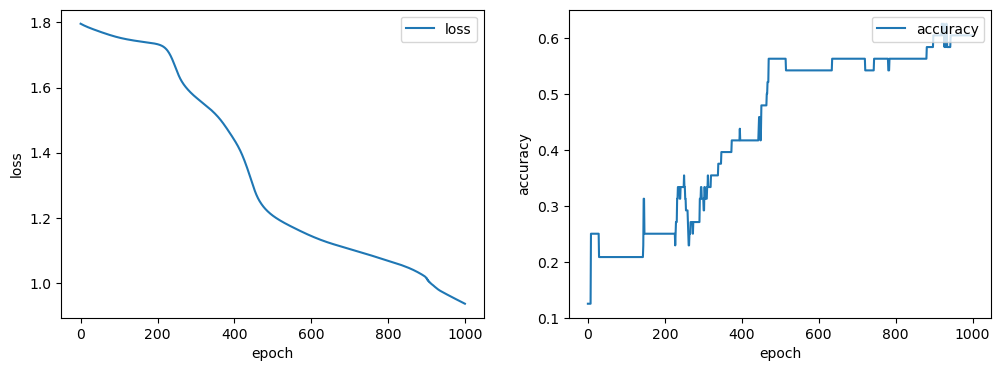

In [348]:
history3 = memory_model3.fit(train_ds, epochs=1000, verbose=0)
utils.plot_history(history3, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

1/1 [==============================] - 0s 425ms/step


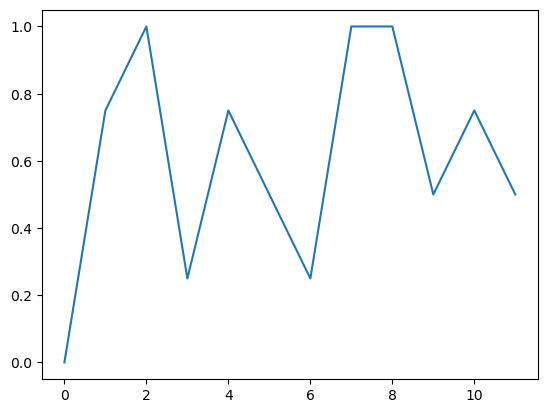

In [349]:
memory_model3.evaluate(train_ds)
memory_model3.evaluate(test_ds)

# plot accuracy as a function of position in sequence
preds3 = memory_model3.predict(train_ds)
preds3 = np.argmax(preds3, axis=-1)
acc_by_pos3 = np.mean(preds3 == train_seqs_y, axis=0)
plt.plot(acc_by_pos3)

sample_input:  [[2 3 1 5 3 4 2 3 1 5 3 4]]
prediction: [2 1 5 5 5 2 5 1 5 5 2 2]
y: [3 1 5 3 4 2 3 1 5 3 4 2]
[False  True  True False False  True False  True  True False False  True]


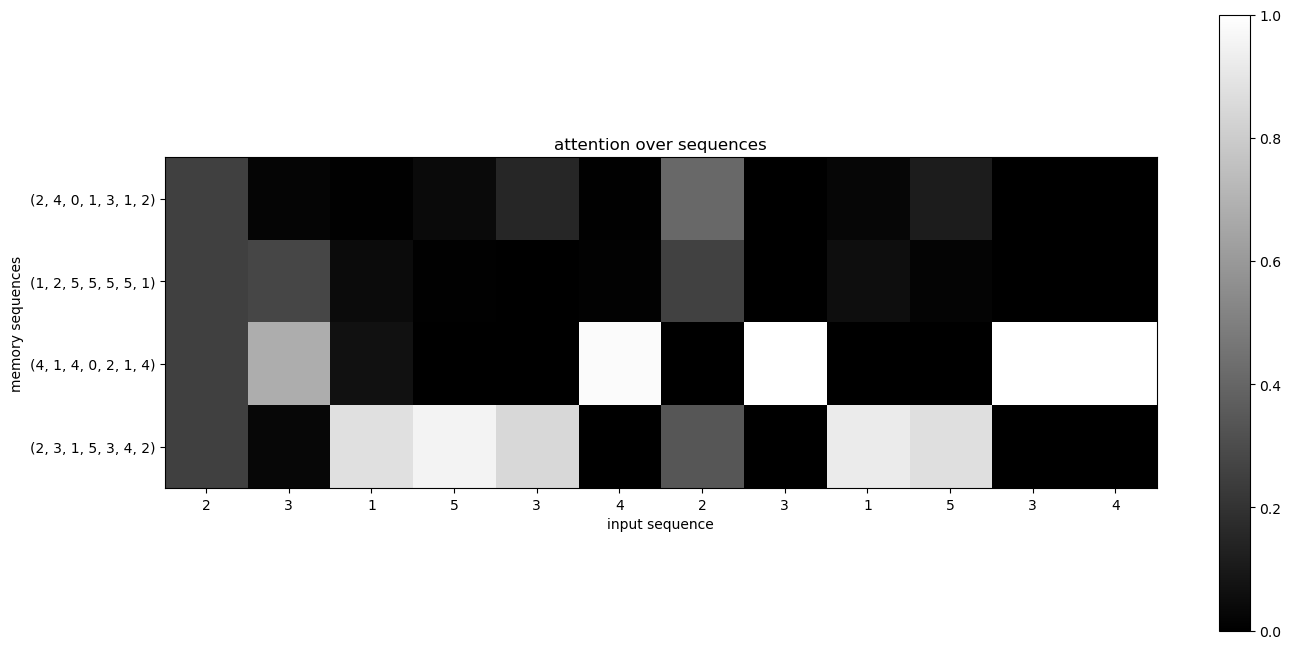

In [352]:
idx = 3
plot_attention(idx, train_seqs_x, train_seqs_y, mem_seqs_x, mem_seqs_y, memory_model3)